## Exploración de los datos

In [ ]:
#Librerias
import numpy as np
import os
from pathlib import Path
from PIL import Image
import pandas as pd

#Librerías de PyTorch
import torch  #PyTorch library
from torch.utils.data import Dataset, DataLoader, sampler, random_split
import torchvision.transforms as tt

#Librerias utiles para plotear
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
%matplotlib inline 
#plots in the line below the code, inside the notebook 

El dataset contiene una carpeta con todos los datos y la siguiente estructura de directorios:

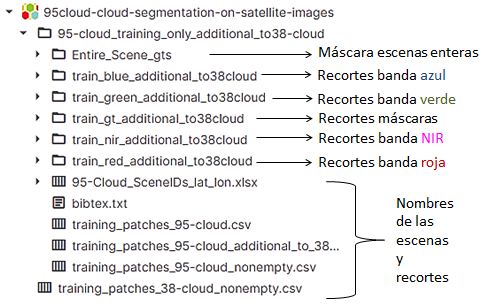

In [ ]:
#Abro el archivo 95-Cloud Scene IDs, tipo excel
ids95 = pd.read_excel('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/95-Cloud_SceneIDs_lat_lon.xlsx')
ids95.head()

Los siguientes enlaces muestran mapas que incluyen el sistema de referencia que utiliza el Landsat 8, junto con las latitudes y longitudes. 

[World Reference System 2- Daytime, descending](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/wrs2.gif)

[World Reference System 2- Nightime, ascending](https://www.usgs.gov/media/images/world-reference-system-2-wrs-2-nightascending)

**LXSS_LLLL_PPPRRR_YYYYMMDD_yyyymmdd_CC_TX**
* L = Landsat (constant)

* X = Sensor (C = OLI / TIRS, O = OLI-only, T= TIRS-only, E = ETM+, T = TM, M= MSS)

* SS = 08 : Landsat 8

* LLLL = L1TP : Processing level, L1TP es corrección de precisión y terreno (L1TP, L1GT, L1GS)

* PPP = WRS path

* RRR = WRS row

* YYYYMMDD = Acquisition Year (YYYY) / Month (MM) / Day (DD)

* yyyymmdd = Processing Year (yyyy) / Month (mm) / Day (dd)

* CC = 01 : Collection number
* TX= RT for Real-Time, T1 for Tier 1 (highest quality), and T2 for Tier 2


Cada carpeta contiene imagenes en formato **TIF**. A continuación explico qué imagenes contiene cada una y muestro un ejemplo.

1. __Escenas enteras__ (*Entire scene ground truth*): Son las mascaras de las escenas enteras, es decir sin recortar, que provee el Landsat. Son imágenes de 8000x8000 pixeles de tamaño, de color 0 ó 255 en escala RGB (negro ó blanco). No las utilizo en este trabajo (no directamente, si utilizo los recortes).

In [ ]:
# Escenas enteras 
print('La carpeta contiene ' + str(len(os.listdir('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/Entire_Scene_gts'))) + ' imágenes.')
es_img = Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/Entire_Scene_gts/edited_corrected_gts_LC08_L1TP_002053_20160520_20170324_01_T1.TIF')
plt.imshow(es_img)

2. __Banda azul__ (*train blue*): Son recortes no superpuestos, de 384x384 pixels de tamaño, de las escenas enteras en la banda visible azul de LANDSAT8. Notar que cada parche se corresponde espacialmente con el mismo parche del resto de las bandas.

In [ ]:
# Banda azul 
print('La carpeta contiene ' + str(len(os.listdir('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_blue_additional_to38cloud'))) + ' imágenes.')
blue_img = Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_blue_additional_to38cloud/blue_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')
plt.imshow(blue_img, cmap='gray')

3. __Banda verde__ (*train green*):  Son recortes no superpuestos, de 384x384 pixels de tamaño,  de las escenas enteras en la banda visible verde de Landsat. Notar que cada parche se corresponde espacialmente con el mismo parche del resto de las bandas. 

In [ ]:
# Banda verde
print('La carpeta contiene ' + str(len(os.listdir('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_green_additional_to38cloud'))) + ' imágenes.')
green_img = Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_green_additional_to38cloud/green_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')
plt.imshow(green_img, 'gray')

4. __Banda roja__ (*train red*):  Son recortes no superpuestos, de 384x384 pixels de tamaño,  de las escenas enteras en la banda visible roja de Landsat. Notar que cada parche se corresponde espacialmente con el mismo parche del resto de las bandas. 

In [ ]:
print('La carpeta contiene ' + str(len(os.listdir('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud'))) + ' imágenes.')
red_img = Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')
plt.imshow(red_img, cmap='gray')

5. __Banda infrarrojo cercano__ (*train nir*):  Son recortes no superpuestos, de 384x384 pixels de tamaño,  de las escenas enteras en la banda del infrarojo cercano de Landsat. Notar que cada parche se corresponde espacialmente con el mismo parche del resto de las bandas. 

In [ ]:
print('La carpeta contiene ' + str(len(os.listdir('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_nir_additional_to38cloud'))) + ' imágenes.')
nir_img = Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_nir_additional_to38cloud/nir_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')
plt.imshow(nir_img, 'gray')

In [ ]:
#Identificaciòn de la escena a la cual pertenece este recorte
ids95.SceneID == 'LC08_L1TP_006248_20160820_20170322_01_T1'
print('Latitud: ' + str(ids95.latitude[2]) + '; Longitud: ' + str(ids95.longitude[2]))

World Reference System 2- Daytime, descending
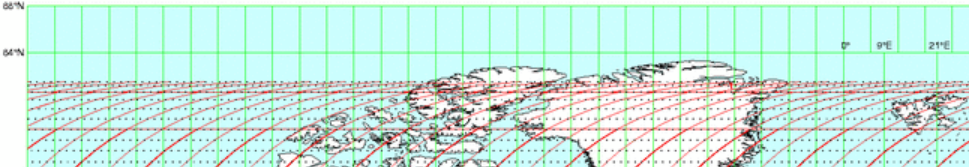

Google Maps
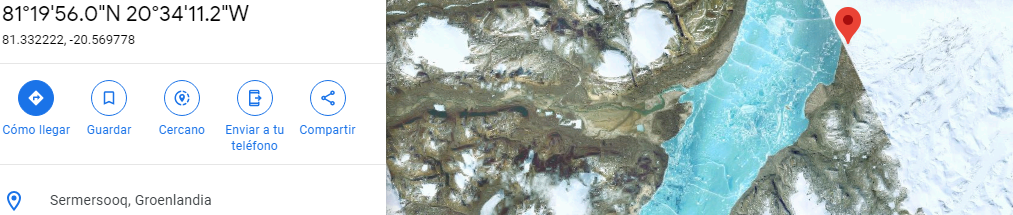

6. __Mascaras recortadas__ (*train gt*): Son los recortes no superpuestos, de 384x384 pixels de tamaño, de las máscaras de las escenas enteras. Son 26301 en total. 

In [ ]:
#Imagen de ground truth

gt_img = Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_gt_additional_to38cloud/gt_patch_100_5_by_12_LC08_L1TP_047011_20160920_20170221_01_T1.TIF')
gt_array = np.array(gt_img)
print('Tamaño: ' + str(gt_array.shape))
print('Maximo = ' + str(gt_array.max()) + ' ; ' + 'Minimo = ' + str(gt_array.min()))
print(gt_array)
gt_img

Finalmente, muestro una imagen con las tres bandas combinadas para formar una imagen RGB, y su respectiva máscara. Notar que no están normalizadas. Elijo esta en particular porque contiene una superficie con nieve y sin nubes y se puede observar claramente que la máscara refleja este hecho.

In [ ]:
r = np.array(Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_368_17_by_16_LC08_L1TP_006248_20160820_20170322_01_T1.TIF'))
r = r/r.max()
g = np.array(Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_green_additional_to38cloud/green_patch_368_17_by_16_LC08_L1TP_006248_20160820_20170322_01_T1.TIF'))
g = g/g.max()
b = np.array(Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_blue_additional_to38cloud/blue_patch_368_17_by_16_LC08_L1TP_006248_20160820_20170322_01_T1.TIF'))
b = b/b.max()
rgb = np.zeros([384,384,3])
rgb[:,:,0] = g
rgb[:,:,1] = b
rgb[:,:,2] = r

plt.figure(figsize=(15,15))

plt.subplot(131)
plt.title('Bandas 2, 3, 4 (visibles), imágen RGB')
plt.imshow(rgb)
plt.subplot(132)
plt.title('Banda 5 (NIR)')
plt.imshow(Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_nir_additional_to38cloud/nir_patch_368_17_by_16_LC08_L1TP_006248_20160820_20170322_01_T1.TIF'), cmap='gray')
plt.subplot(133)
plt.title('Máscara')
plt.imshow(Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_gt_additional_to38cloud/gt_patch_368_17_by_16_LC08_L1TP_006248_20160820_20170322_01_T1.TIF'))

plt.show()

In [ ]:
#Identificaciòn de la escena a la cual pertenece este recorte
ids95.SceneID == 'LC08_L1TP_006248_20160820_20170322_01_T1'
print('Latitud: ' + str(ids95.latitude[2]) + '; Longitud: ' + str(ids95.longitude[2]))

## Preparación de los datos

### Partir el conjunto de datos

El primer paso es partir el conjunto de datos en tres partes:

* **Entrenamiento** (*training*): se utiliza para entrenar el modelo, es decir calcular las perdidas y ajustar los pesos utilizando gradient descent. En este caso contendrá 15000 imágenes. 
* **Validación** (*validation*): se utiliza para evaluar el modelo mientras se está entrenado, ajustar los hiperparámetros y elegir el mejor modelo. En este caso, contendrá 5000 imágenes, que representan un 25% del tamaño del conjunto de datos de entrenamiento + validación (generalmente tener un conjunto con 80% de datos para entrenamiento y 20% para validación es un buen punto de partida)
* **Prueba** (*test*): se utiliza una vez finalizado el entrenamiento como un parámetro para entender qué tan bien entrenó el modelo. Es decir, concluido el entrenamiento le paso al modelo imágenes que nunca vió, que están en este conjunto, y compruebo qué tan bien puede predecir la prescencia de nubes. En este caso, contendrá las 6301 imágenes restantes.

Para ello creé la siguiente función que recibe el path de una carpeta y carga los nombres de los archivos en una lista, divide la lista 3 partes de los tamaños desados y devuelve tres listas con las direcciones de los archivos en objetos tipo Path. 

In [ ]:
def data_split(red_dir, train_size, val_size):
    '''
    Función que carga los nombres de todos los archivos de una dirección en una lista, 
    divide la lista en 3 partes de tamaños train_size la primera, val_size la segunda y tamaño total -(train_size + val_size) la tercera.
    Finalmente, convierte todas las direcciones que eran str en objetos tipo Path.
    Devuelve las 3 listas con las direcciones en formato Path.
    
    Parameters:
    -----------
    
    red_dir: str. Direccion de la carpeta de la banda roja
    train_size: int. Tamaño del dataset de entrenamiento
    val_size: int. Tamaño del dataset de validacion
    
    Return:
    -------
    (train_list, val_list, test_list)
    
    '''
    
    if not (isinstance(red_dir, str)):
        raise AttributeError('red_dir must be a string')
    
    a = os.listdir(red_dir)
    b = np.split(a,[train_size,train_size+val_size,len(a)]) #necesito que siga siendo lista para partirlo
    train_files = b[0]
    val_files = b[1]
    test_files = b[2]
    
    train_list = []
    val_list = []
    test_list = []
    
    r_dir = Path(red_dir)

    for file_name in train_files:
        train_list.append(r_dir/file_name)
        
    for file_name in val_files:
        val_list.append(r_dir/file_name)
        
    for file_name in test_files:
        test_list.append(r_dir/file_name)
      
    return train_list, val_list, test_list 

In [ ]:
#Cargo la lista de archivos partida
total_list = data_split('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud', 15000, 5000)
len(total_list)

In [ ]:
#Compruebo las longitudes de cada sub-lista
print(len(total_list[0])) #training
print(len(total_list[1])) #validation
print(len(total_list[2])) #test

In [ ]:
# Un objeto de la sub-lista train, el que está en la posición 3
total_list[0][3] 

### Necesidad de la definicion de la clase CloudDataset
 
Para poder cargar las imagenes en un dataset y que el modelo funcione, a cada parche o recorte debo:

- convertir esa imagen TIF en un array de numpy
- juntarlo con los parches que le corresponden espacialmete del resto de las bandas (stackear los 4 parches)
- convertir ese arreglo 4-dimensional en un tensor de PyTorch

Podria hacer esto, guardar todos los archivos como imágenes PIL y cargarlos con la función ImageFolder o Datafolder pero tardaría mas y la memoria no alcanza (Kaggle ofrece 4.9 GB de memoria mientras que las imagenes ocupan 17.29 GB). La solución es crear una clase que herede de la clase **torch.util.data.Dataset**, una subclase. Esta va a cumplir la misma función: cargar los datos en un Dataset y devolver los *inputs*, en este caso los recortes de las imágenes RGB, con sus correspondientes *targets*, en este caso la máscara correspondiente a cada recorte, pero además debemos agregarle otras funcionalidades especialmente adaptadas a este dataset. 

La documentación de la clase **torch.utils.data.Dataset** dice que todas sus subclases deben sobreescribir el método __ __getitem__()__ , que es el método que devuelve los _inputs_ y _targets_. Opcionalmente pueden sobreescribir el metodo __ __len__()__ , del cual se espera que devuelva el tamaño del dataset.

In [ ]:
class CloudDataset(Dataset): #Subclase de la clase Dataset
    
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, file_list, pytorch=True): #parametros
        super().__init__() #para instanciar la clase
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in file_list if not f.is_dir()]
        self.pytorch = pytorch #NO SE QUE HACE
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        files = {'red': r_file, 
                 'green': g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}
        return files
                                       
    def __len__(self):
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)  # normalized
    

    def open_mask(self, idx, add_dims=False):
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        return x, y
    
    def open_as_pil(self, idx):
        arr = 256*self.open_as_array(idx)
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())
        return s

__Explicacion por partes:__

__class__ CloudDataset(Dataset): --> crea la subclase CloudDataset de la clase Dataset
> 
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True): 
        super().__init__() #para instanciar la clase
        
Define los parametros que le voy a pasar a la clase, luego instancia la clase. Los parámetros son:
1. r_dir: str. Dirección donde están los recortes de imágenes en la banda visible roja.
2. g_dir: str. Dirección donde están los recortes de imágenes en la banda visible verde.
3. b_dir: str. Dirección donde están los recortes de imágenes en la banda visible azul.
4. nir_dir: str. Dirección donde están los recortes de imágenes en la banda del infrarojo cercano.
5. gt_dir: str. Dirección donde están los recortes de imágenes de las máscaras.
6. file_list: lista de los paths de los archivos. 
7. pytorch: Bool. Activa la librería PyTorch.

Lo siguiente itera a traves de los archivos en la carpeta r_dir y combina cada imagen de este canal (rojo) con la misma imagen (espacial) pero en los otros canales y su correpondiente máscara.
 
     for file in r_dir.iterdir():
         if not file.is_dir(): 
             self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir)]
     #self.pytorch = pytorch NO SE QUE HACE
        

La función __file.is_dir()__ Devuelve True si el path apunta a un directorio (carpeta); False si apunta a otro tipo de archivo o el path no existe ó está roto. 

- Funcion __combine_files__

         def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
             files = {'red': r_file, 
                 'green': g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}
        return files        
A cada imagen de la carpeta del canal rojo que va abriendo, la combina en un diccionario con la misma imagen espacial pero en otros canales. Para cada elemento, la _clave_ es el nombre del canal y el _valor_ es la direccion (tipo Path) de la imagen. Por eso para los canales que no son el rojo, por ejemplo para la carpeta green abre el mismo archivo pero donde dice red cambia por green.  
        
- Función __len__

        def __len__(self):
            return len(self.files)
Devuelve la cantidad de elementos del dataset.

- Funcion __open_as_array__

        def open_as_array(self, idx, invert=False, include_nir=False):
            raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
            if include_nir:
                nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
                raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
            if invert:
                raw_rgb = raw_rgb.transpose((2,0,1))
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)   # normalize       
Abre las imagenes RGB normalizadas como arrays de Numpy. Además se puede agregar una dimensión al array que contiene la banda del infrarrojo cercano (claramente si se activa esta función no es posible graficar la imagen como RGB por ejemplo con plt.imshow).
iinfo param = The kind of integer data type to get information about.

- Función **open_as_pil**

        def open_as_pil(self, idx):
        arr = 256*self.open_as_array(idx)
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
Abre las imágenes RGB como imágenes PIL. 

A continuación utilizo esta clase:

In [ ]:
#direccion de la carpeta principal que contiene todas las imagenes
path_ppal = Path('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud')

In [ ]:
#Cargo los archivos del conjunto de entrenamiento en un dataset, es el primer elemento de la lista total_lista
train_dataset = CloudDataset(path_ppal/'train_red_additional_to38cloud', 
                    path_ppal/'train_green_additional_to38cloud', 
                    path_ppal/'train_blue_additional_to38cloud', 
                    path_ppal/'train_nir_additional_to38cloud',
                    path_ppal/'train_gt_additional_to38cloud',
                    total_list[0])
len(train_dataset)

In [ ]:
#Cargo los archivos del conjunto de validación en un dataset, es el segundo elemento de la lista total_lista
val_dataset = CloudDataset(path_ppal/'train_red_additional_to38cloud', 
                    path_ppal/'train_green_additional_to38cloud', 
                    path_ppal/'train_blue_additional_to38cloud', 
                    path_ppal/'train_nir_additional_to38cloud',
                    path_ppal/'train_gt_additional_to38cloud',
                    total_list[1])
len(val_dataset)

In [ ]:
#Cargo los archivos del conjunto de testeo en un dataset, es el tercer elemento de la lista total_lista
test_dataset = CloudDataset(path_ppal/'train_red_additional_to38cloud', 
                    path_ppal/'train_green_additional_to38cloud', 
                    path_ppal/'train_blue_additional_to38cloud', 
                    path_ppal/'train_nir_additional_to38cloud',
                    path_ppal/'train_gt_additional_to38cloud',
                    total_list[2])
len(test_dataset)

In [ ]:
#Compruebo las formas de los objetos de los datasets
x, y = train_dataset[0]
x.shape, y.shape

In [ ]:
#Abro un archivo como una imagen PIL
plt.imshow(train_dataset.open_as_pil(13234))

In [ ]:
#Abro el mismo archivo como un np.array
array = train_dataset.open_as_array(13234)
rgb = np.zeros([384,384,3])
rgb[:,:,0] = array[:,:,1]
rgb[:,:,1] = array[:,:,0]
rgb[:,:,2] = array[:,:,2]

plt.imshow(rgb)
rgb.max()

In [ ]:
#Abro un archivo como array y su correspondiente máscara
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(train_dataset.open_as_array(3570))
ax[1].imshow(train_dataset.open_mask(3570))

### Dataloaders
Creo los dataloaders y defino el tamaño de batch para cargar el dataset en batches.

In [ ]:
batch_size = 16

In [ ]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
def show_batch(dl): #OJO CON LOS CANALES!!
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0), cmap='gray')
        
        #fig2, ax2 = plt.subplots(figsize=(8, 8))
        #ax2.set_xticks([]); ax2.set_yticks([])
        
        #ax2.imshow(make_grid(labels, nrow=4).permute(1, 2,0))
        
        break

In [ ]:
show_batch(train_dl)

In [ ]:
show_batch(val_dl)

In [ ]:
#Por que usar la banda nir, descripción gráfica
gt2_img = Image.open('../input/95cloud-cloud-segmentation-on-satellite-images/95-cloud_training_only_additional_to38-cloud/train_nir_additional_to38cloud/nir_patch_100_5_by_12_LC08_L1TP_054019_20160820_20170221_01_T1.TIF')
plt.imshow(gt2_img, cmap='gray')

## Fuentes:
* Clase CloudDataset: https://medium.com/analytics-vidhya/how-to-create-a-custom-dataset-loader-in-pytorch-from-scratch-for-multi-band-satellite-images-c5924e908edf